# Logarithmic spiral modelling using Bayesian statistics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.optimize import minimize
import theano
import theano.tensor as tt
from gzbuilderspirals import pa_from_r_theta
from gzbuilderspirals.oo import Pipeline, Arm

In [2]:
plt.style.use('seaborn')

In [3]:
a = Arm.load('lib/spiral_arms/20902040-0.pickle')
arm = Arm(a.get_parent(), a.arms)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DBSCAN from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator BayesianRidge from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.20.2 when using version 0.21.0. This might lea

In [4]:
t = arm.t
R = arm.R
ls = arm.polar_logsp
gzb_pa = arm.chirality * arm.pa

Non-weighted least squares pitch angle: -12.729˚


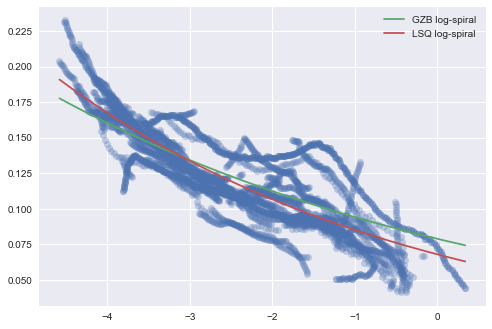

In [5]:
def logsp(t, a, phi):
    b = np.tan(np.deg2rad(phi))
    return a * np.exp(b*t)

def f(p):
    model = logsp(t, *p)
    return np.sum(np.abs(R - model)**2)

res = minimize(
    f,
    (0.1, arm.pa * arm.chirality)
)
plt.plot(t, R, 'o', alpha=0.3)
plt.plot(ls[0], ls[1], label='GZB log-spiral')
plt.plot(ls[0], logsp(ls[0], *res['x']), label='LSQ log-spiral')
plt.legend();
print('Non-weighted least squares pitch angle: {:.3f}˚'.format(res['x'][1]))

TODO: point-weighting

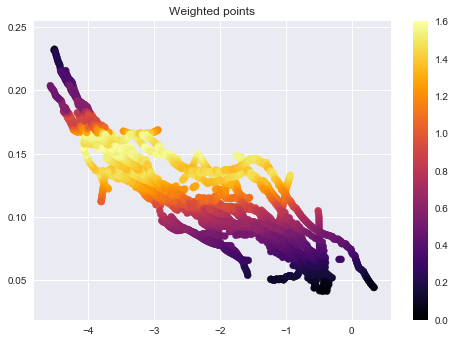

In [6]:
sc = plt.scatter(
    t, R,
    vmin=arm.point_weights.min(),
    vmax=arm.point_weights.max(),
    c=arm.point_weights,
    cmap=plt.cm.get_cmap('inferno'),
)
plt.colorbar(sc)
plt.title('Weighted points');

In [7]:
pw_mask = arm.point_weights != 0
with pm.Model() as model:
#     phi_mu = pm.Uniform('phi_mu', lower=-90, upper=90, 
#                      testval=arm.chirality * arm.pa)
#     phi_sd = pm.HalfCauchy('phi_sd', beta=10, testval=1)
#     phi = pm.Normal('phi', mu=phi_mu, sd=phi_sd, testval=arm.chirality * arm.pa)
    phi = pm.Uniform('phi', lower=-90, upper=90, 
                     testval=arm.chirality * arm.pa)
    a = pm.Uniform('a', lower=0, upper=1)

    mu_r = a * tt.exp(tt.tan(phi * np.pi / 180) * t[pw_mask])
    base_sigma = pm.HalfCauchy('sigma', beta=10, testval=.1)
    sigma_y = theano.shared(
        np.asarray(np.sqrt(arm.point_weights[pw_mask]), dtype=theano.config.floatX),
        name='sigma_y'
    )
    sigmas = base_sigma / sigma_y
    likelihood = pm.Normal('R', mu=mu_r, sd=sigmas, observed=R[pw_mask])

    trace = pm.sample(2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, phi]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:27<00:00, 220.67draws/s]
The acceptance probability does not match the target. It is 0.9276421460426195, but should be close to 0.8. Try to increase the number of tuning steps.


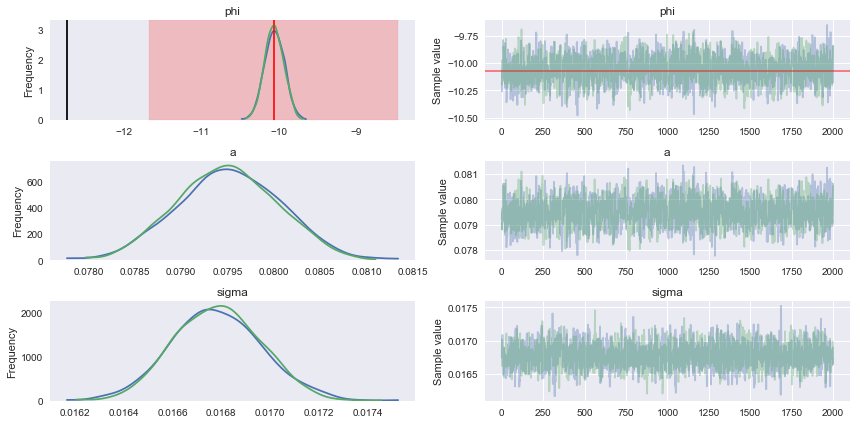

In [8]:
n_vars = sum(1 for i in trace.varnames if not i[-2:] == '__')
f, ax = plt.subplots(ncols=2, nrows=n_vars, figsize=(4 * n_vars, 6))
pm.traceplot(trace, lines={'phi': arm.chirality * arm.pa}, ax=ax)
plt.sca(ax[0][0])
l = ax[0][0].get_ylim()[1]
plt.fill_betweenx([0, l], *np.array((-1, 1)) * arm.sigma_pa + arm.chirality * arm.pa, color='r', alpha=0.2)
ax[0][0].vlines(res['x'][-1], 0, ax[0][0].get_ylim()[1])

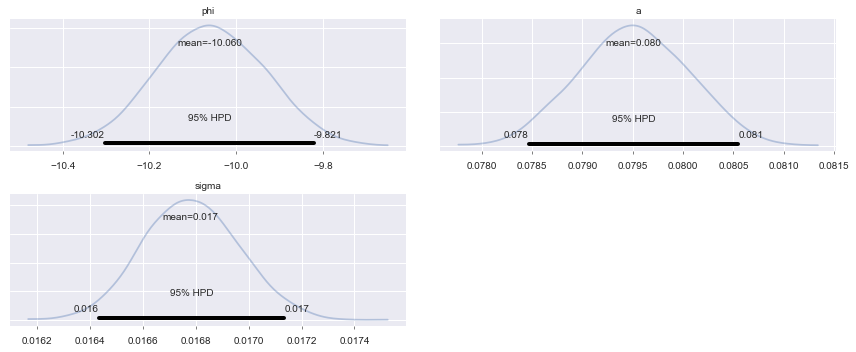

In [9]:
pm.plots.plot_posterior(trace, kde_plot=True);

In [10]:
phi_samples = np.expand_dims(trace['phi'][500:], 1)
a_samples = np.expand_dims(trace['a'][500:], 1)
t_ = np.linspace(t.min(), t.max(), 50)
p_t = a_samples * np.exp(np.tan(np.deg2rad(phi_samples)) * t_)

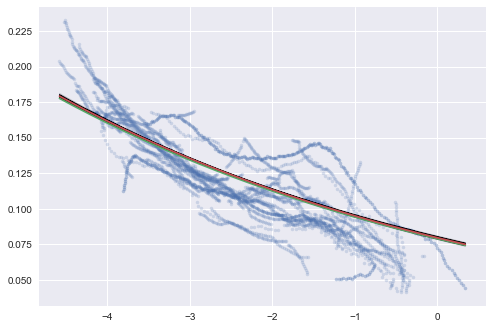

In [11]:
plt.plot(t, R, '.', alpha=0.2)
choice = np.random.choice(np.arange(len(p_t)), size=1000, replace=False)
for s in p_t[choice]:
    plt.plot(t_, s, 'k', alpha=0.005)
plt.plot(ls[0], ls[1], label='GZB log spiral')
plt.plot(ls[0], logsp(ls[0], trace['a'].mean(), trace['phi'].mean()),
         label='PMY3 log spiral')

Pas
	GZB:  -10.07˚ ± 1.603
	PYMC: -10.06˚ ± 0.124


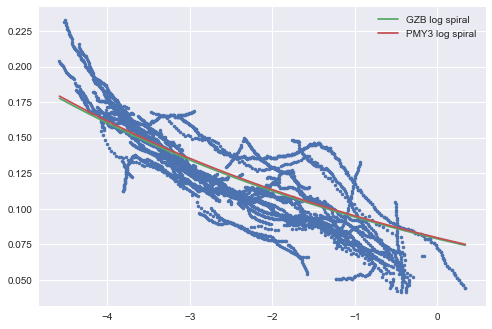

In [12]:
print('Pas')
print('\tGZB:  {:.2f}˚ ± {:.3f}'.format(
    arm.pa * arm.chirality, arm.sigma_pa
))
print('\tPYMC: {:.2f}˚ ± {:.3f}'.format(
    trace['phi'].mean(),
    trace['phi'].std(),
))
plt.plot(t, R, '.')
plt.plot(ls[0], ls[1], label='GZB log spiral')
plt.plot(ls[0], logsp(ls[0], trace['a'].mean(), trace['phi'].mean()),
         label='PMY3 log spiral')
plt.legend();

Fitting a global pitch angle for a galaxy

In [13]:
import os
from numba import jit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [14]:
sid = 20902008
arms = [Arm.load('lib/spiral_arms/{}'.format(f)) for f in os.listdir('lib/spiral_arms/') if str(sid) in f]
arms

/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DBSCAN from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator BayesianRidge from version 0.20.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.20.2 when using version 0.21.0. This might lea

IndexError: index 2 is out of bounds for axis 0 with size 2

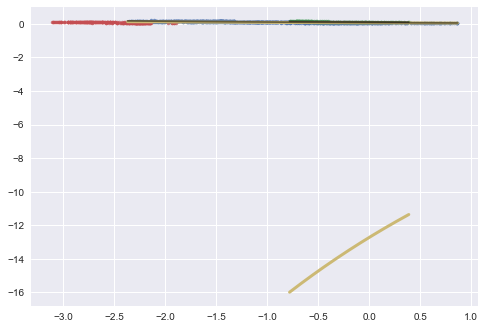

In [15]:
for a in arms:
  plt.plot(a.t, a.R, '.', alpha=0.7)
# @jit(nopython=True)
def lsp(A, pa, t):
  return A * np.exp(pa * np.pi / 180 * t)

pipeline = arms[0].get_parent()

def f(p):
  As = p[:-1]
  phi = p[-1]
  return sum(mean_squared_error(a.R, lsp(As[i], phi, a.t), sample_weight=a.point_weights) for i, a in enumerate(arms))

gal_pa, gal_sigma_pa = pipeline.get_pitch_angle(arms)

res_comb = minimize(f, [0.1]*len(arms) + [gal_pa * arms[0].chirality])
for i, a in enumerate(arms):
    o = np.argsort(a.t)
    plt.plot(a.t[o], lsp(res['x'][i], res_comb['x'][-1], a.t[o]), 'C{}'.format(len(arms)+1), linewidth=3)
    plt.plot(*a.polar_logsp, 'k', alpha=0.5)

plt.plot([], [], 'k', alpha=0.5, label='Fits for individual $\phi$')
plt.plot([], [], 'k', c='C{}'.format(len(arms)+1), linewidth=3, label='Fits for combined $\phi$')

print('Combined fit: {}˚'.format(res_comb['x'][-1]))
print('Length-weighted average fit: {}˚ ± {}'.format(arms[0].chirality * gal_pa, np.std([a.pa for a in arms])))
plt.legend()

In [16]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline, make_pipeline

In [17]:
def get_log_spiral_pipeline():
    names = ('polynomialfeatures', 'bayesianridge')
    steps = [
        PolynomialFeatures(
            degree=1,
            include_bias=False,
        ),
        TransformedTargetRegressor(
            regressor=BayesianRidge(
                compute_score=True,
                fit_intercept=True,
                copy_X=True,
                normalize=True,
                **clf_kwargs
            ),
            func=np.log,
            inverse_func=np.exp
        )
    ]
    return Pipeline(memory=None, steps=list(zip(names, steps)))